In [34]:
from collections import Counter, defaultdict
import math
import pandas as pd


In [66]:
def read_fasta(file_path):
    seq = ""
    with open(file_path) as f:
        for line in f:
            if not line.startswith(">"):
                seq += line.strip()
    return seq.upper()

cds_sequence = read_fasta("cds_from_genomics.fna")


In [97]:
stop_codons = {"TAA", "TAG", "TGA"}

# Trim to multiple of 3
cds_sequence = cds_sequence[:len(cds_sequence) - len(cds_sequence) % 3]

assert len(cds_sequence) % 3 == 0


In [127]:
def split_into_codons(seq):
    return [seq[i:i+3] for i in range(0, len(seq), 3)]

codons = split_into_codons(cds_sequence)

# Remove stop codons
codons = [c for c in codons if c not in stop_codons]


In [151]:
codon_table = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L",
    "CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","CAT":"H","CAC":"H",
    "CAA":"Q","CAG":"Q","AAT":"N","AAC":"N",
    "AAA":"K","AAG":"K","GAT":"D","GAC":"D",
    "GAA":"E","GAG":"E","TGT":"C","TGC":"C",
    "TGG":"W","CGT":"R","CGC":"R","CGA":"R","CGG":"R",
    "AGT":"S","AGC":"S","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G"
}


In [179]:
codon_counts = Counter(codons)

aa_codon_counts = defaultdict(dict)
for codon, count in codon_counts.items():
    aa = codon_table[codon]
    aa_codon_counts[aa][codon] = count


In [206]:
rscu = {}

for aa, codon_dict in aa_codon_counts.items():
    total = sum(codon_dict.values())
    n = len(codon_dict)
    for codon, count in codon_dict.items():
        rscu[codon] = count / (total / n)


In [219]:
weights = {}

for aa, codon_dict in aa_codon_counts.items():
    max_rscu = max(rscu[c] for c in codon_dict)
    for codon in codon_dict:
        weights[codon] = rscu[codon] / max_rscu


In [268]:
def calculate_cai(codons, weights):
    log_sum = 0
    valid = 0

    for codon in codons:
        if codon in weights and weights[codon] > 0:
            log_sum += math.log(weights[codon])
            valid += 1

    return math.exp(log_sum / valid)

original_cai = calculate_cai(codons, weights)
original_cai


0.7137171012093827

In [292]:
best_codon_for_aa = {}

for aa, codon_dict in aa_codon_counts.items():
    best_codon_for_aa[aa] = max(
        codon_dict, key=lambda c: rscu[c]
    )


In [315]:
optimized_codons = []

for codon in codons:
    aa = codon_table[codon]
    optimized_codons.append(best_codon_for_aa[aa])

optimized_cds = "".join(optimized_codons)


In [350]:
optimized_cai = calculate_cai(optimized_codons, weights)

print("Original CAI :", round(original_cai, 4))
print("Optimized CAI:", round(optimized_cai, 4))


Original CAI : 0.7137
Optimized CAI: 1.0


In [391]:
df_compare = pd.DataFrame({
    "Original_Count": Counter(codons),
    "Optimized_Count": Counter(optimized_codons)
}).fillna(0).astype(int)

df_compare["Difference"] = (
    df_compare["Optimized_Count"] - df_compare["Original_Count"]
)

df_compare.sort_values("Difference", ascending=False).head(15)


,Original_Count,Optimized_Count,Difference
GCG,45350,126113,80763
CTG,68078,141638,73560
AGC,21692,81294,59602
GTG,34540,93934,59394
GGC,38257,94871,56614
CGC,30172,78775,48603
ACC,30597,73004,42407
ATT,39325,79492,40167
CCG,31550,61156,29606
GAT,40498,64723,24225


In [411]:
assert len(codons) == len(optimized_codons)


In [430]:
comparison = []

for i, (orig, opt) in enumerate(zip(codons, optimized_codons), start=1):
    comparison.append({
        "Position": i,
        "Original_Codon": orig,
        "Optimized_Codon": opt,
        "Changed": orig != opt
    })

df_check = pd.DataFrame(comparison)
df_check.head(20)


,Position,Original_Codon,Optimized_Codon,Changed
0,1,ATG,ATG,False
1,2,AAA,AAA,False
2,3,CGC,CGC,False
3,4,ATT,ATT,False
4,5,AGC,AGC,False
5,6,ACC,ACC,False
6,7,ACC,ACC,False
7,8,ATT,ATT,False
8,9,ACC,ACC,False
9,10,ACC,ACC,False


In [431]:
df_check[df_check["Changed"] == True].head(20)


,Position,Original_Codon,Optimized_Codon,Changed
11,12,ATC,ATT,True
15,16,ACA,ACC,True
16,17,GGT,GGC,True
18,19,GGT,GGC,True
22,23,CGA,CGC,True
24,25,TTG,CTG,True
25,26,AAG,AAA,True
26,27,TTC,TTT,True
28,29,GGT,GGC,True
29,30,ACA,ACC,True


In [464]:
changed_count = df_check["Changed"].sum()
total_codons = len(df_check)

print(f"Changed codons: {changed_count}/{total_codons}")
print(f"Change percentage: {changed_count/total_codons*100:.2f}%")


Changed codons: 655167/1333831
Change percentage: 49.12%


In [465]:
aa_check = []

for orig, opt in zip(codons, optimized_codons):
    aa_check.append({
        "Original_AA": codon_table[orig],
        "Optimized_AA": codon_table[opt],
        "Same_AA": codon_table[orig] == codon_table[opt]
    })

df_aa = pd.DataFrame(aa_check)

assert df_aa["Same_AA"].all(), "❌ Amino acid sequence changed!"
print("✅ Protein sequence preserved")


✅ Protein sequence preserved


In [466]:
df_usage = pd.DataFrame({
    "Original": Counter(codons),
    "Optimized": Counter(optimized_codons)
}).fillna(0).astype(int)

df_usage["Increase"] = df_usage["Optimized"] - df_usage["Original"]
df_usage.sort_values("Increase", ascending=False).head(10)


,Original,Optimized,Increase
GCG,45350,126113,80763
CTG,68078,141638,73560
AGC,21692,81294,59602
GTG,34540,93934,59394
GGC,38257,94871,56614
CGC,30172,78775,48603
ACC,30597,73004,42407
ATT,39325,79492,40167
CCG,31550,61156,29606
GAT,40498,64723,24225


In [467]:
df_check.sample(10)


,Position,Original_Codon,Optimized_Codon,Changed
1302025,1302026,TCC,AGC,True
355824,355825,CTC,CTG,True
237456,237457,GAT,GAT,False
1028046,1028047,GCC,GCG,True
1004582,1004583,GCG,GCG,False
205253,205254,CTG,CTG,False
96688,96689,AAC,AAC,False
1120310,1120311,ACC,ACC,False
1188375,1188376,ATG,ATG,False
1286193,1286194,AAG,AAA,True


In [468]:
total_codons = len(codons)
optimized_count = sum(
    1 for o, n in zip(codons, optimized_codons) if o != n
)

percent_optimized = (optimized_count / total_codons) * 100

print(f"Total codons        : {total_codons}")
print(f"Optimized codons    : {optimized_count}")
print(f"Percent optimized   : {percent_optimized:.2f}%")


Total codons        : 1333831
Optimized codons    : 655167
Percent optimized   : 49.12%


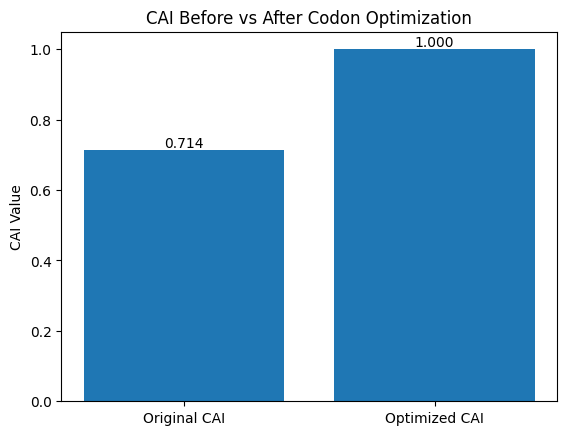

In [469]:
import matplotlib.pyplot as plt

labels = ["Original CAI", "Optimized CAI"]
values = [original_cai, optimized_cai]

plt.figure()
plt.bar(labels, values)
plt.ylabel("CAI Value")
plt.title("CAI Before vs After Codon Optimization")

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")

plt.show()


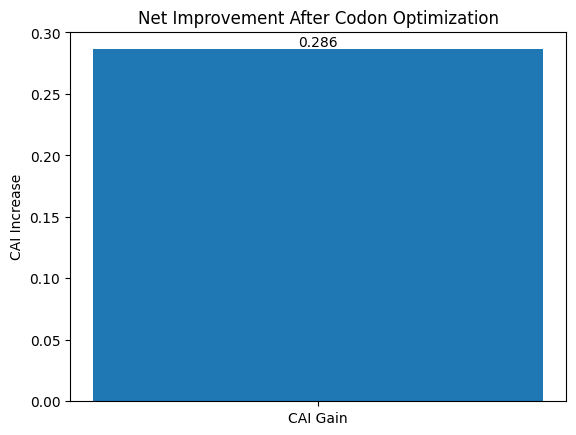

In [470]:
plt.figure()
plt.bar(["CAI Gain"], [optimized_cai - original_cai])
plt.ylabel("CAI Increase")
plt.title("Net Improvement After Codon Optimization")
plt.text(0, optimized_cai - original_cai, 
         f"{optimized_cai - original_cai:.3f}", 
         ha="center", va="bottom")
plt.show()


In [471]:
aa_original = [codon_table[c] for c in codons]
aa_optimized = [codon_table[c] for c in optimized_codons]

aa_loss = sum(o != n for o, n in zip(aa_original, aa_optimized))
aa_loss_percent = (aa_loss / len(aa_original)) * 100

print(f"Amino acid changes       : {aa_loss}")
print(f"Protein data loss (%)    : {aa_loss_percent:.2f}%")


Amino acid changes       : 0
Protein data loss (%)    : 0.00%


In [472]:
codon_changes = sum(o != n for o, n in zip(codons, optimized_codons))
codon_loss_percent = (codon_changes / len(codons)) * 100

print(f"Codons changed           : {codon_changes}")
print(f"Codon-level change (%)   : {codon_loss_percent:.2f}%")


Codons changed           : 655167
Codon-level change (%)   : 49.12%


In [473]:
unique_original = len(set(codons))
unique_optimized = len(set(optimized_codons))

diversity_loss = unique_original - unique_optimized
diversity_loss_percent = (diversity_loss / unique_original) * 100

print(f"Unique codons (original) : {unique_original}")
print(f"Unique codons (optimized): {unique_optimized}")
print(f"Diversity loss (%)       : {diversity_loss_percent:.2f}%")


Unique codons (original) : 61
Unique codons (optimized): 20
Diversity loss (%)       : 67.21%


In [474]:
pd.DataFrame({
    "Metric": [
        "Protein data loss",
        "Codon changes",
        "Codon diversity loss"
    ],
    "Value (%)": [
        aa_loss_percent,
        codon_loss_percent,
        diversity_loss_percent
    ]
})


,Metric,Value (%)
0,Protein data loss,0.000000
1,Codon changes,49.119191
2,Codon diversity loss,67.213115


In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

orig_counts = Counter(codons)
opt_counts = Counter(optimized_codons)

df_usage = pd.DataFrame({
    "Original": orig_counts,
    "Optimized": opt_counts
}).fillna(0)

df_usage.head()


,Original,Optimized
ATG,37133,37133.0
AAA,44506,60176.0
CGC,30172,78775.0
ATT,39325,79492.0
AGC,21692,81294.0


In [476]:
df_freq = df_usage.copy()

df_freq["Original"] = df_freq["Original"] / df_freq["Original"].sum()
df_freq["Optimized"] = df_freq["Optimized"] / df_freq["Optimized"].sum()

df_freq.head()


,Original,Optimized
ATG,0.027839,0.027839
AAA,0.033367,0.045115
CGC,0.022621,0.059059
ATT,0.029483,0.059597
AGC,0.016263,0.060948


In [477]:
heatmap_data = df_freq.T.values   # shape: 2 x number_of_codons
codon_labels = df_freq.index.tolist()


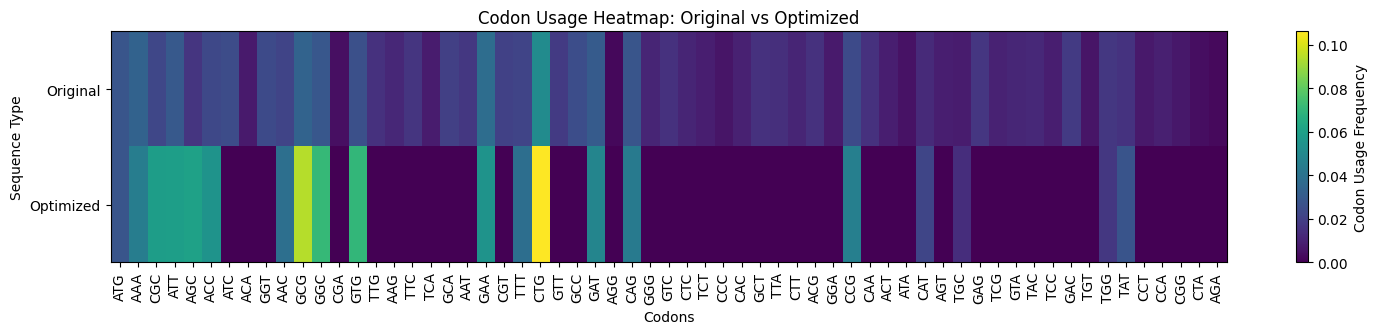

In [478]:
plt.figure(figsize=(18, 3))

plt.imshow(heatmap_data, aspect="auto")
plt.colorbar(label="Codon Usage Frequency")

plt.yticks([0, 1], ["Original", "Optimized"])
plt.xticks(range(len(codon_labels)), codon_labels, rotation=90)

plt.title("Codon Usage Heatmap: Original vs Optimized")
plt.xlabel("Codons")
plt.ylabel("Sequence Type")

plt.show()


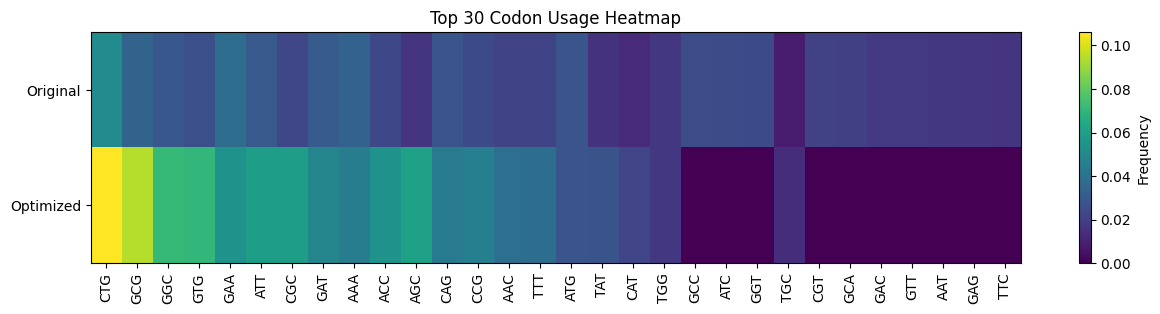

In [479]:
top_codons = df_usage.sum(axis=1).sort_values(ascending=False).head(30).index
df_small = df_freq.loc[top_codons]

plt.figure(figsize=(15, 3))
plt.imshow(df_small.T.values, aspect="auto")
plt.colorbar(label="Frequency")
plt.yticks([0,1], ["Original", "Optimized"])
plt.xticks(range(len(top_codons)), top_codons, rotation=90)
plt.title("Top 30 Codon Usage Heatmap")
plt.show()
